In [1]:
from Modelling.Baselines.build_samples import import_samples_for_baseline
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import keras
import numpy as np
import matplotlib.pyplot as plt
from Code.image_functions import *
from Code.find_path_nextcloud import find_path_nextcloud
import tensorflow

In [2]:
# load model
model = keras.models.load_model('baseline1.h5')

In [3]:
# find project path in nextcloud
path_nextcloud = find_path_nextcloud()

# define path with data
path_folder = path_nextcloud + 'Daten_Gyrocopter/Oldenburg'

path_labeled_folder = path_folder + '/Teilbilder/grid_200_200/subimages'

In [4]:

# Liste aller Dateien in annotation_folder erstellen
files = os.listdir(path_labeled_folder)

# Aus Liste files .hdr Dateien löschen
for file in files:
    if not file.endswith('.dat'):
        files.remove(file)

for file in files:
    if 'wrong_image_size' in file:
        files.remove(file)

# Spaltennamen des DataFrames bilden
path_combined_hdr = path_folder + '/Oldenburg_combined_HSI_THERMAL_DOM.hdr'
path_combined_dat = path_folder + '/Oldenburg_combined_HSI_THERMAL_DOM.dat'

# read image
img = envi.open(file=path_combined_hdr, image=path_combined_dat)

def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

# convert only wavelength into dataframe and round numbers
value_bands = ['hsi_band_' + str(int(float(x))) + '_nm' for x in img.metadata['wavelength'] if isfloat(x)]
value_bands.extend(['thermal', 'dom'])


In [11]:
# predicted Bilder erstellen
for filename in files:
    path_dat = path_labeled_folder + '/' + os.path.splitext(filename)[0] + '.dat'
    path_hdr = path_labeled_folder + '/' + os.path.splitext(filename)[0] + '.hdr'
    img = spy.envi.open(file=path_hdr, image=path_dat)

    arr = img.load()

    df = pd.DataFrame(arr.reshape(((arr.shape[0]*arr.shape[1]), arr.shape[2])), columns=value_bands)

    X = tensorflow.convert_to_tensor(df, dtype=tensorflow.float32)

    # prediction
    y_pred = model.predict(X)
    # choose argmax
    df['y_pred'] = y_pred.argmax(axis=1)
    img_arr = np.array(df, dtype=float)
    img_arr = np.reshape(img_arr, (arr.shape[0], arr.shape[1], 110))


    # fig, ax = plt.subplots(figsize=(10, 10))
    # ax.imshow(img_arr[:, :, -1])
    # plt.show()
    # fig.savefig(os.path.splitext(filename)[0])

    # save Subimage
    path_export = path_folder + '/predicted_subimages'
    if not os.path.exists(path_export):
        os.makedirs(path_export)

    path_hdr = path_export + '/' + os.path.splitext(filename)[0] + '.hdr'

    envi.save_image(hdr_file=path_hdr, image=img_arr,
                    dtype="float32", ext='.dat', interleave='bsq',
                    metadata=img.metadata, force=True)




563/563 [==============================] - 1s 2ms/step


**Zusammenführen**

In [12]:
# read image
img = envi.open(file=path_combined_hdr, image=path_combined_dat)

# extract grid_size
windowsize_c = int(200)
windowsize_r = int(200)

# define export folder name
grid_folder = path_export

# Select all .dat Subimages

# build list with all files in grid_folder
files_lst = os.listdir(grid_folder)

# remove unwanted files from files_lst
unwanted_pattern = ['.hdr', 'combined_big_picture', 'rgb', '.xml', 'labeled']
for pattern in unwanted_pattern:
    for file in files_lst:
        if pattern in file:
            files_lst.remove(file)

# build export folder
if not os.path.exists(path_export):
    os.makedirs(path_export)

# define big picture name
path_big_picture_hdr = path_export + '/grid_' + str(windowsize_r) + '_' + str(
    windowsize_c) + '_combined_big_picture.hdr'

# build empty envi file with matching dimension
img.metadata['bands'] = 110
grid = envi.create_image(hdr_file=path_big_picture_hdr, metadata=img.metadata, dtype="float32", ext='.dat',
                         interleave='bsq',
                         force=True)

# create writeable access
writer = grid.open_memmap(writable=True)

# combine subimages with writer method

# Iteration over all .dat subimages
for file in files_lst:
    # extract grid position from grid filename which has a name convention
    file_split = file.split('_')
    grid_pos_r = int(file_split[2]) * windowsize_r  # Gridposition row
    grid_pos_c = int(file_split[3]) * windowsize_c  # Gridposition column

    # define path-filename-combination from .hdr and .dat file
    path_hdr = grid_folder + "/" + file[:-4] + '.hdr'
    path_dat = grid_folder + "/" + file

    # read subimage
    image_small = envi.open(file=path_hdr, image=path_dat)

    image_small_arr = image_small.load()
    # if image_small_arr.shape[2] == 109:
    #     zero_mask = np.ones((image_small_arr.shape[0], image_small_arr.shape[1], 1)) * -1
    #     image_small_arr = np.concatenate((image_small_arr, zero_mask), -1)

    # insert subimage in grid
    writer[grid_pos_r:grid_pos_r + windowsize_r, grid_pos_c:grid_pos_c + windowsize_c, :] = image_small_arr

# read big picture
path_big_picture_dat = path_big_picture_hdr[:-4] + '.dat'
big_picture = envi.open(file=path_big_picture_hdr, image=path_big_picture_dat)

In [14]:
arr = big_picture.load()

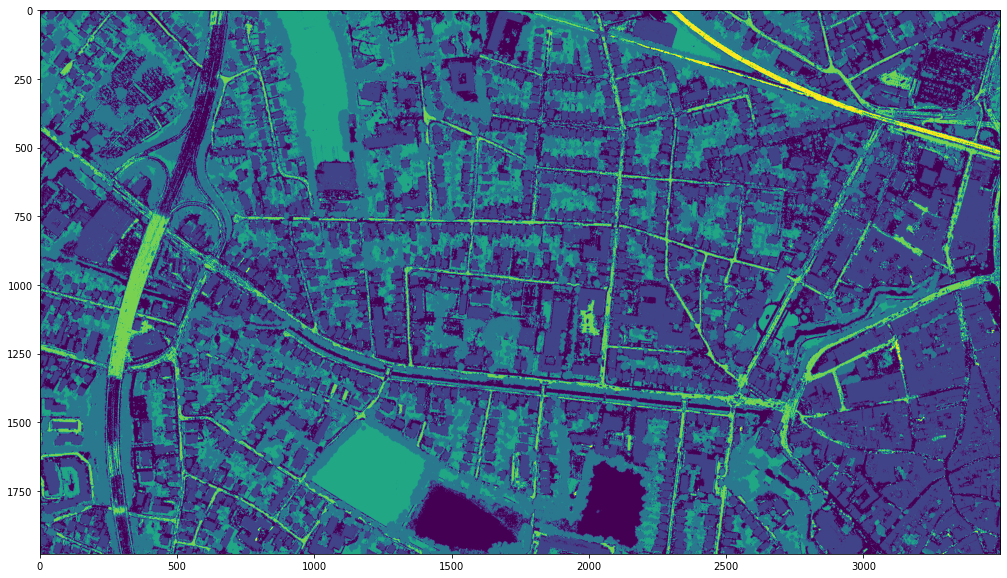

In [22]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(arr[:, :, -1])
plt.show()
fig.savefig('big_picture_prediction')

In [18]:
rgb_image = spy.get_rgb(arr, bands=(59, 26, 1), stretch=(0.01, 0.99), stretch_all=True)

C:\Users\fgrassxx\AppData\Local\Temp\ipykernel_5736\1228725065.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


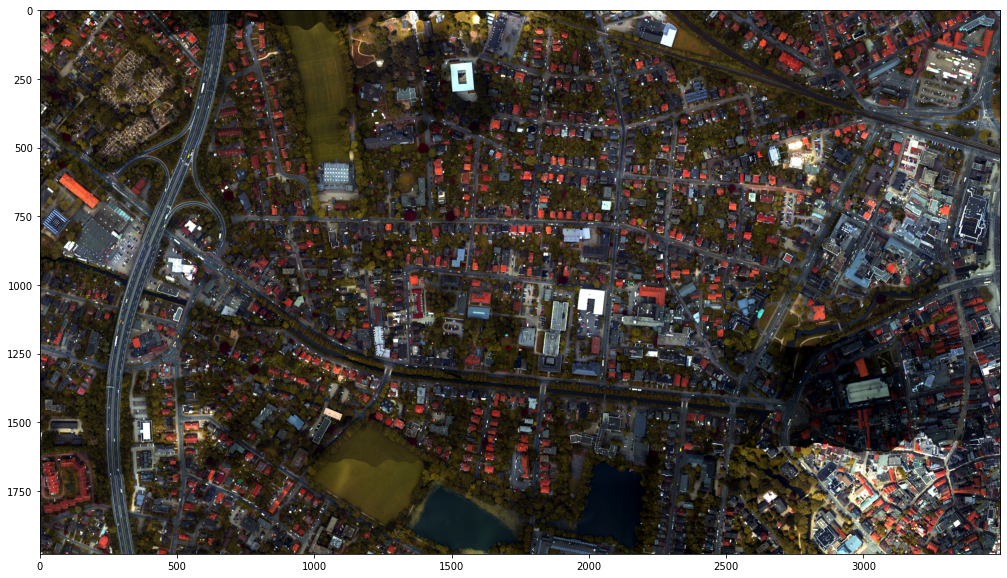

In [21]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(rgb_image)
fig.show()

In [ ]:
value_bands.append('pred')

In [31]:
value_bands.remove('pred')

In [32]:
df = pd.DataFrame(arr.reshape(((arr.shape[0]*arr.shape[1]), arr.shape[2])), columns=value_bands)

In [65]:
df.head()

hsi_band_430_nm  hsi_band_434_nm  hsi_band_439_nm  hsi_band_443_nm  \
0           1314.0           1369.0           1487.0           1572.0   
1           1301.0           1389.0           1501.0           1557.0   
2           1362.0           1494.0           1543.0           1546.0   
3           1502.0           1382.0           1530.0           1489.0   
4           1502.0           1382.0           1530.0           1489.0   

   hsi_band_448_nm  hsi_band_452_nm  hsi_band_457_nm  hsi_band_461_nm  \
0           1614.0           1671.0           1701.0           1689.0   
1           1679.0           1699.0           1715.0           1785.0   
2           1649.0           1715.0           1736.0           1787.0   
3           1680.0           1713.0           1830.0           1784.0   
4           1680.0           1713.0           1830.0           1784.0   

   hsi_band_466_nm  hsi_band_470_nm  ...  hsi_band_901_nm  hsi_band_906_nm  \
0           1754.0           1777.0  ...           2791.0           2609.0   
1           1799.0           1790.0  ...           2482.0           2544.0   
2           1828.0           1861.0  ...           2581.0           2713.0   
3           1808.0           1883.0  ...           2819.0           2760.0   
4           1808.0           1883.0  ...           2819.0           2760.0   

   hsi_band_911_nm  hsi_band_916_nm  hsi_band_921_nm  hsi_band_925_nm  \
0           2557.0           2600.0           2592.0           2554.0   
1           2654.0           2488.0           2486.0           2551.0   
2           2511.0           2450.0           2713.0           2579.0   
3           2694.0           2875.0           2806.0           2623.0   
4           2694.0           2875.0           2806.0           2623.0   

   thermal  dom  pred       color_pred  
0      0.0  0.0   0.0  [235, 235, 235]  
1      0.0  0.0   0.0  [235, 235, 235]  
2      0.0  0.0   0.0  [235, 235, 235]  
3      0.0  0.0   0.0  [235, 235, 235]  
4      0.0  0.0   0.0  [235, 235, 235]  

[5 rows x 111 columns]

In [95]:
# df['color_pred'] = df['pred'].map({0.0:[0,0,0], # schwarz
#                                    1.0:np.array([188,238,104]), # hellgrün -> Haus
#                                    2.0:np.array([255,64,64]), # rot -> Wald
#                                    3.0:np.array([255,165,0]), # orange -> Wiese
#                                    4.0:np.array([255,20,147]), # pink -> Straße
#                                    5.0:np.array([34,139,34])}) # dunkelgrün -> Schienen
# # ['None', 'Wiese','Straße','Schienen','Haus','Wald']

In [135]:
df['color_pred'] = df['pred'].map({0.0:np.array([0,0,0]), # schwarz
                                   1.0:np.array([205,38,38]), # rot -> Haus
                                   2.0:np.array([34,139,34]), # dunkelgrün -> Wald
                                   3.0:np.array([188,238,104]), # hellgrün -> Wiese
                                   4.0:np.array([140,140,140]), # grau -> Straße
                                   5.0:np.array([255,20,147])}) # pink -> Schienen
# ['None', 'Wiese','Straße','Schienen','Haus','Wald']

In [136]:
df['color_pred1'] = df['color_pred'].apply(lambda x: x[0])
df['color_pred2'] = df['color_pred'].apply(lambda x: x[1])
df['color_pred3'] = df['color_pred'].apply(lambda x: x[2])

In [137]:
img_arr = np.array(df[['color_pred1', 'color_pred2', 'color_pred3']])

In [138]:
img_arr = np.reshape(img_arr, (arr.shape[0], arr.shape[1],3))

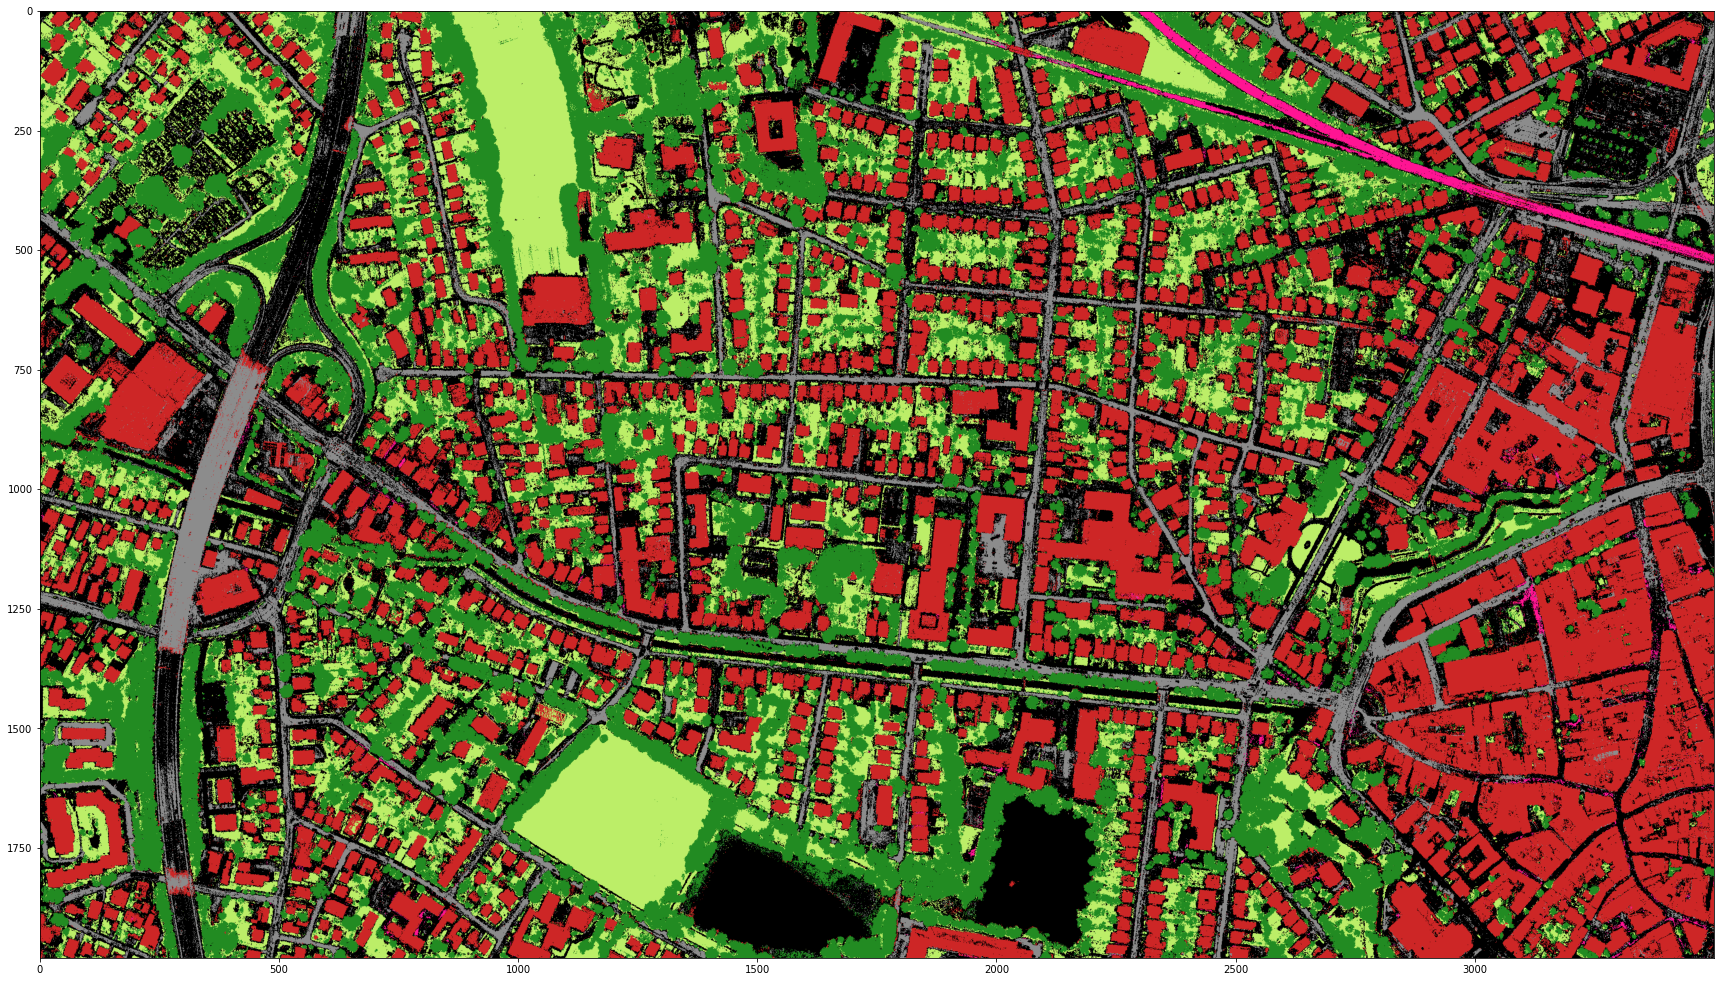

In [140]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow(img_arr)
plt.show()
fig.savefig('big_picture_prediction', dpi=300) # ['None', 'Wiese','Straße','Schienen','Haus','Wald']